In [1]:
## imports
from qiskit import *
from qiskit.algorithms import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import quantum_info, IBMQ, Aer,providers
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
# backend = BasicAer.get_backend("statevector_simulator")
# quantum_instance = QuantumInstance(backend)
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_finance.circuit.library import LogNormalDistribution, NormalDistribution
from qiskit.algorithms import AmplitudeEstimation
#from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector
import numpy as np
from numpy import pi
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as plt

In [2]:
# setup simulator using IBM_id
# IBMQ.save_account("1c62e8a0d2b058d0e797db9c811bc34582df5553e25812301cd1518662c0ab68d2378ac6c197b65f8be944d04b7e7439f034e3926a44fa8088538b3d13782c1a", overwrite= True)
provider = IBMQ.load_account()
IBMQ.get_provider(hub='ibm-q-education', group='iit-madras-1', project='quantum-computin')
# setup required backends 
lima = provider.get_backend('ibmq_lima')
manila = provider.get_backend('ibmq_manila')
qsm_simulator = Aer.get_backend('qasm_simulator')
stv_simulator = Aer.get_backend('statevector_simulator')
aer = Aer.get_backend('aer_simulator')

## Helper Functions

In [3]:
def crot(qc, l):
    if l == 0:
        return qc
    l = l-1
    qc.h(l)
    for q in range(l):
        qc.cp(pi/2**(l-q), q, l)
    #qc.barrier()
    # qc.draw()
    
def QFT(qc):
   """function to generate QFT circuit """
   dim = qc.num_qubits
   for q in range(dim):
      crot(qc, dim-q)
   for q in range(int(dim/2)):
      qc.swap(q, dim-q-1)

   #qc.draw()
   return qc
   

In [5]:
# ## equal superpostion of qreg ~
# def prep():
#     qreg = QuantumRegister(nbit, name= 'qreg')
#     ancilla = AncillaRegister(1, name= 'ancilla')
#     qc = QuantumCircuit(qreg, ancilla) 
#     qc.h(qreg)

#     return qc.to_gate()

## fucntion evaluation circuit ~
def feval(nmax,nbit):
    qreg = QuantumRegister(nbit, name= 'qreg')
    ancilla = QuantumRegister(1, name= 'ancilla')
    qc = QuantumCircuit(qreg, ancilla, name= 'f_eval') 

    qc.ry(nmax/(2**nbit), ancilla)
    for qubit in range(nbit): qc.cry(nmax/(2**(nbit - qubit- 1)), qubit, ancilla )

    return qc.to_gate()

## generate generalised grover operators ~
def Q0(nmax, nbit):
    qreg = QuantumRegister(nbit, name= 'qreg')
    ancilla = QuantumRegister(1, name= 'ancilla')
    qc = QuantumCircuit(qreg, ancilla, name= 'Q0') 

    qc.z(ancilla)
    return qc

def Q1(nmax, nbit):
    qreg = QuantumRegister(nbit, name= 'qreg')
    ancilla = QuantumRegister(1, name= 'ancilla')
    qc = QuantumCircuit(qreg, ancilla, name= "Q1") 

    qc.append(feval(nmax, nbit), list(range(nbit+1)))
    qc.h(qreg)

    qc.x(qreg)
    qc.x(ancilla)
    qc.h(ancilla)
    qc.mcx(list(range(len(qreg))), ancilla)
    qc.h(ancilla)
    qc.x(ancilla)
    qc.x(qreg)
    

    qc.h(qreg)
    qc.append(feval(nmax, nbit).inverse(), list(range(nbit+1)))
    
    return qc

def grover(nbit, nmax, steps):
    qreg = QuantumRegister(nbit, name= 'qreg')
    ancilla = QuantumRegister(1, name= 'ancilla')
    qc = QuantumCircuit(qreg, ancilla, name= 'grover^'+ str(steps))

    q0 = Q0(nmax, nbit).to_gate()
    q1 = Q1(nmax, nbit).to_gate()


    for step in range(steps):
        qc.compose(q0, inplace= True)
        qc.compose(q1, inplace= True)

    return qc.to_gate()


## Numerical Integration using QAE

## Expectation of Boolen function 

In [6]:
## defining distributions ~
num_qubits = 4

## distribution: [normal/ log-normal ]
d_nrml = NormalDistribution(num_qubits, mu = 0, sigma= 1 )

d_nrml.draw()

┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1      ├
     │  P(X) │
q_2: ┤2      ├
     │       │
q_3: ┤3      ├
     └───────┘

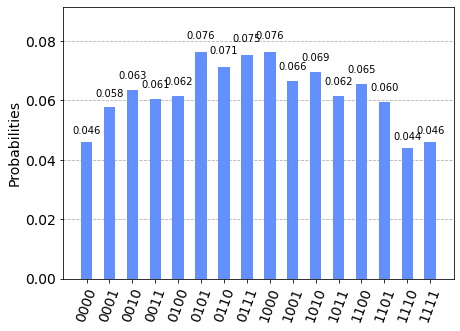

In [7]:
d_nrml.measure_all()
job = execute(d_nrml, backend= aer)
plot_histogram(job.result().get_counts(),sort= 'asc')

In [8]:
## defining a arbitrary linear function 
lae = LinearAmplitudeFunction(num_qubits, 1, -1.0, (0,1),(-1,1), name= 'lae_1' )
lae.draw()

┌────────┐
q41_0: ┤0       ├
       │        │
q41_1: ┤1       ├
       │        │
q41_2: ┤2 lae_1 ├
       │        │
q41_3: ┤3       ├
       │        │
  q42: ┤4       ├
       └────────┘

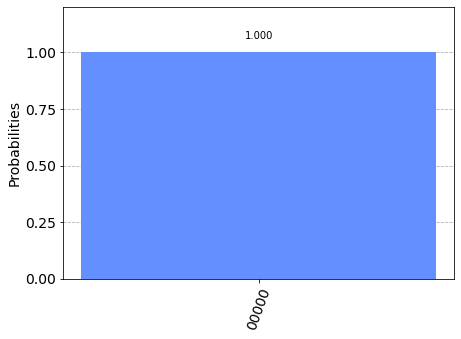

In [9]:
lae.measure_all()
job = execute(lae, backend= aer)
plot_histogram(job.result().get_counts(),sort= 'asc')

In [10]:
qc = lae.compose(d_nrml, qubits= [0,1,2,3] ,front= True)
qc.draw()

┌───────┐ ░ ┌─┐         ┌────────┐ ░ ┌─┐            
 q41_0: ┤0      ├─░─┤M├─────────┤0       ├─░─┤M├────────────
        │       │ ░ └╥┘┌─┐      │        │ ░ └╥┘┌─┐         
 q41_1: ┤1      ├─░──╫─┤M├──────┤1       ├─░──╫─┤M├─────────
        │  P(X) │ ░  ║ └╥┘┌─┐   │        │ ░  ║ └╥┘┌─┐      
 q41_2: ┤2      ├─░──╫──╫─┤M├───┤2 lae_1 ├─░──╫──╫─┤M├──────
        │       │ ░  ║  ║ └╥┘┌─┐│        │ ░  ║  ║ └╥┘┌─┐   
 q41_3: ┤3      ├─░──╫──╫──╫─┤M├┤3       ├─░──╫──╫──╫─┤M├───
        └───────┘ ░  ║  ║  ║ └╥┘│        │ ░  ║  ║  ║ └╥┘┌─┐
   q42: ─────────────╫──╫──╫──╫─┤4       ├─░──╫──╫──╫──╫─┤M├
                     ║  ║  ║  ║ └────────┘ ░  ║  ║  ║  ║ └╥┘
meas: 5/═════════════╩══╩══╩══╩═══════════════╩══╩══╩══╩══╩═
                     0  1  2  3               0  1  2  3  4

In [11]:
# qc.measure([0,1,2,3])
# job = execute(qc, backend= aer)
# plot_histogram(job.result().get_counts(),sort= 'asc')

## Integrating $ \frac{1}{n_{max}} \int_{0}^{n_{max}} sin^{2}(x) dx$ numerically


In [46]:
## discretization of the integral domain x in [0, 2^{n}-1] by using n qubits ~
nmax = pi / 5  # upper limit of integral
nbit = 10  # change this value to get discretized result closer to analytical results

analyticResult = (nmax / 2.0 - np.sin(2 * nmax) / 4.0 ) / nmax  # the target integral can be analytically solved
print("Analytical Result:", analyticResult)

ndiv = 2**nbit  #number of discretization 
discretizedResult = 0.0
for i in range(ndiv):
    discretizedResult += np.sin(nmax / ndiv * (i + 0.5))**2
discretizedResult = discretizedResult / ndiv
print("Discretized Result:", discretizedResult)

Analytical Result: 0.12158663567967151
Discretized Result: 0.12158661193451378


In [47]:
qreg = QuantumRegister(nbit, name= 'qreg')
ancilla = QuantumRegister(1, name= 'ancilla')
qc = QuantumCircuit(qreg, ancilla) 

qc.h(qreg)
qc.append(feval(nmax, nbit), list(range(nbit+1)))
qc.barrier()

# qc.compose(grover(nbit, nmax, 2), inplace= True)

qc.draw()

┌───┐┌──────────┐ ░ 
 qreg_0: ┤ H ├┤0         ├─░─
         ├───┤│          │ ░ 
 qreg_1: ┤ H ├┤1         ├─░─
         ├───┤│          │ ░ 
 qreg_2: ┤ H ├┤2         ├─░─
         ├───┤│          │ ░ 
 qreg_3: ┤ H ├┤3         ├─░─
         ├───┤│          │ ░ 
 qreg_4: ┤ H ├┤4         ├─░─
         ├───┤│          │ ░ 
 qreg_5: ┤ H ├┤5  f_eval ├─░─
         ├───┤│          │ ░ 
 qreg_6: ┤ H ├┤6         ├─░─
         ├───┤│          │ ░ 
 qreg_7: ┤ H ├┤7         ├─░─
         ├───┤│          │ ░ 
 qreg_8: ┤ H ├┤8         ├─░─
         ├───┤│          │ ░ 
 qreg_9: ┤ H ├┤9         ├─░─
         └───┘│          │ ░ 
ancilla: ─────┤10        ├─░─
              └──────────┘ ░

Using MLE method

In [48]:
## estimation sub-routine
def likelihood(grovers , shots, p_vals = np.linspace(0, 2*pi, 100)):
    dic = {}
    for p in p_vals: 
        dic[p] = p**(grovers) 
    return dic

def combine_likelihood(lkhs):
    dic = lkhs[0]
    for lkh in lkhs[1:]: 
        for theta in lkh.keys():
            dic[theta] = dic[theta]*lkh[theta]
            
    return dic

def generate_le(nbit, nmax, grovers= 1, shots= 100 , p_val = np.linspace(0.10, 0.15, 50) ):
    qreg = QuantumRegister(nbit, name= 'qreg')
    ancilla = QuantumRegister(1, name= 'ancilla')
    qc = QuantumCircuit(qreg, ancilla) 

    qc.h(qreg)
    qc.append(feval(nmax, nbit), list(range(nbit+1)))
    qc.barrier()

    qc.compose(grover(nbit, nmax, grovers), inplace= True)

    ## since we know that the itegral evaluuates to 0.12158663567967151 we pick the domain ~
    
    

    return qc



In [52]:
qc = generate_le(nbit, nmax, grovers= 0 )
creg= ClassicalRegister(1, name= 'creg')
qc.add_register(creg)
qc.measure(ancilla, creg)

qc.draw()

┌───┐┌──────────┐ ░ ┌────────────┐   
 qreg_0: ┤ H ├┤0         ├─░─┤0           ├───
         ├───┤│          │ ░ │            │   
 qreg_1: ┤ H ├┤1         ├─░─┤1           ├───
         ├───┤│          │ ░ │            │   
 qreg_2: ┤ H ├┤2         ├─░─┤2           ├───
         ├───┤│          │ ░ │            │   
 qreg_3: ┤ H ├┤3         ├─░─┤3           ├───
         ├───┤│          │ ░ │            │   
 qreg_4: ┤ H ├┤4         ├─░─┤4           ├───
         ├───┤│          │ ░ │            │   
 qreg_5: ┤ H ├┤5  f_eval ├─░─┤5  grover^0 ├───
         ├───┤│          │ ░ │            │   
 qreg_6: ┤ H ├┤6         ├─░─┤6           ├───
         ├───┤│          │ ░ │            │   
 qreg_7: ┤ H ├┤7         ├─░─┤7           ├───
         ├───┤│          │ ░ │            │   
 qreg_8: ┤ H ├┤8         ├─░─┤8           ├───
         ├───┤│          │ ░ │            │   
 qreg_9: ┤ H ├┤9         ├─░─┤9           ├───
         └───┘│          │ ░ │            │┌─┐
ancilla: ─────┤10        ├─░─┤10          ├┤M├
              └──────────┘ ░ └────────────┘└╥┘
 creg: 1/═══════════════════════════════════╩═
                                            0

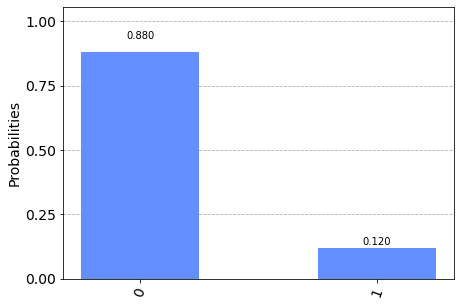

In [55]:
shots= 1200
job = execute(qc, backend= aer, shots= shots)
counts = job.result().get_counts()
plot_histogram(counts)


In [56]:
counts['1']/shots

0.12

In [43]:
counts

{'1': 13, '0': 107}

Using QPE method.

In [58]:
qreg = QuantumRegister(nbit, name= 'qreg')
ancilla = QuantumRegister(1, name= 'ancilla')
qc = QuantumCircuit(qreg, ancilla) 

precision = 4
preg = QuantumRegister(precision, name= 'precision_q')
clreg = ClassicalRegister(precision, name= 'creg')

qc.h(qreg)
qc.append(feval(nmax, nbit), list(range(nbit+1)))
qc.barrier()

qc.add_register(preg, clreg)
qc.draw()

┌───┐┌──────────┐ ░ 
       qreg_0: ┤ H ├┤0         ├─░─
               ├───┤│          │ ░ 
       qreg_1: ┤ H ├┤1         ├─░─
               ├───┤│          │ ░ 
       qreg_2: ┤ H ├┤2         ├─░─
               ├───┤│          │ ░ 
       qreg_3: ┤ H ├┤3         ├─░─
               ├───┤│          │ ░ 
       qreg_4: ┤ H ├┤4         ├─░─
               ├───┤│          │ ░ 
       qreg_5: ┤ H ├┤5  f_eval ├─░─
               ├───┤│          │ ░ 
       qreg_6: ┤ H ├┤6         ├─░─
               ├───┤│          │ ░ 
       qreg_7: ┤ H ├┤7         ├─░─
               ├───┤│          │ ░ 
       qreg_8: ┤ H ├┤8         ├─░─
               ├───┤│          │ ░ 
       qreg_9: ┤ H ├┤9         ├─░─
               └───┘│          │ ░ 
      ancilla: ─────┤10        ├─░─
                    └──────────┘ ░ 
precision_q_0: ────────────────────
                                   
precision_q_1: ────────────────────
                                   
precision_q_2: ────────────────────
                                   
precision_q_3: ────────────────────
                                   
       creg: 4/════════════════════

In [59]:
# qc.barrier()
qc.h(preg)
for q in range(precision):
    qc.append(grover(nbit, nmax, 2**q).control(1), [nbit+1+q]+list(range(nbit+1)) )

qftgate_inv = QFT(QuantumCircuit(precision, name='QFT')).to_gate().inverse()
qc.barrier()
qc.append(qftgate_inv, list(range(nbit+1, nbit+1+precision)) ) 

qc.draw()


┌───┐┌──────────┐ ░ ┌────────────┐┌────────────┐┌────────────┐»
       qreg_0: ┤ H ├┤0         ├─░─┤0           ├┤0           ├┤0           ├»
               ├───┤│          │ ░ │            ││            ││            │»
       qreg_1: ┤ H ├┤1         ├─░─┤1           ├┤1           ├┤1           ├»
               ├───┤│          │ ░ │            ││            ││            │»
       qreg_2: ┤ H ├┤2         ├─░─┤2           ├┤2           ├┤2           ├»
               ├───┤│          │ ░ │            ││            ││            │»
       qreg_3: ┤ H ├┤3         ├─░─┤3           ├┤3           ├┤3           ├»
               ├───┤│          │ ░ │            ││            ││            │»
       qreg_4: ┤ H ├┤4         ├─░─┤4           ├┤4           ├┤4           ├»
               ├───┤│          │ ░ │            ││            ││            │»
       qreg_5: ┤ H ├┤5  f_eval ├─░─┤5  grover^1 ├┤5  grover^2 ├┤5  grover^4 ├»
               ├───┤│          │ ░ │            ││            ││            │»
       qreg_6: ┤ H ├┤6         ├─░─┤6           ├┤6           ├┤6           ├»
               ├───┤│          │ ░ │            ││            ││            │»
       qreg_7: ┤ H ├┤7         ├─░─┤7           ├┤7           ├┤7           ├»
               ├───┤│          │ ░ │            ││            ││            │»
       qreg_8: ┤ H ├┤8         ├─░─┤8           ├┤8           ├┤8           ├»
               ├───┤│          │ ░ │            ││            ││            │»
       qreg_9: ┤ H ├┤9         ├─░─┤9           ├┤9           ├┤9           ├»
               └───┘│          │ ░ │            ││            ││            │»
      ancilla: ─────┤10        ├─░─┤10          ├┤10          ├┤10          ├»
               ┌───┐└──────────┘ ░ └─────┬──────┘└─────┬──────┘└─────┬──────┘»
precision_q_0: ┤ H ├─────────────────────■─────────────┼─────────────┼───────»
               ├───┤                                   │             │       »
precision_q_1: ┤ H ├───────────────────────────────────■─────────────┼───────»
               ├───┤                                                 │       »
precision_q_2: ┤ H ├─────────────────────────────────────────────────■───────»
               ├───┤                                                         »
precision_q_3: ┤ H ├─────────────────────────────────────────────────────────»
               └───┘                                                         »
       creg: 4/══════════════════════════════════════════════════════════════»
                                                                             »
«               ┌────────────┐ ░            
«       qreg_0: ┤0           ├─░────────────
«               │            │ ░            
«       qreg_1: ┤1           ├─░────────────
«               │            │ ░            
«       qreg_2: ┤2           ├─░────────────
«               │            │ ░            
«       qreg_3: ┤3           ├─░────────────
«               │            │ ░            
«       qreg_4: ┤4           ├─░────────────
«               │            │ ░            
«       qreg_5: ┤5  grover^8 ├─░────────────
«               │            │ ░            
«       qreg_6: ┤6           ├─░────────────
«               │            │ ░            
«       qreg_7: ┤7           ├─░────────────
«               │            │ ░            
«       qreg_8: ┤8           ├─░────────────
«               │            │ ░            
«       qreg_9: ┤9           ├─░────────────
«               │            │ ░            
«      ancilla: ┤10          ├─░────────────
«               └─────┬──────┘ ░ ┌─────────┐
«precision_q_0: ──────┼────────░─┤0        ├
«                     │        ░ │         │
«precision_q_1: ──────┼────────░─┤1        ├
«                     │        ░ │  QFT_dg │
«precision_q_2: ──────┼────────░─┤2        ├
«                     │        ░ │         │
«precision_q_3: ──────■────────░─┤3        ├
«                              ░ └─────────┘
«       creg:

In [60]:
qc.measure(preg, clreg)
job = execute(qc, backend= aer, shots= 2000)
counts = job.result().get_counts()
# counts

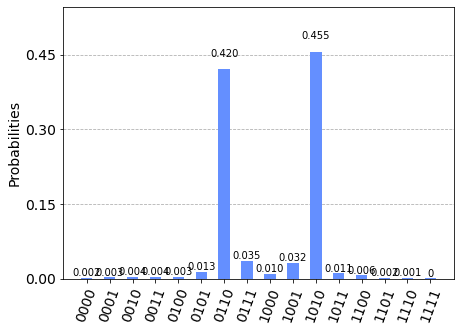

In [61]:
plot_histogram(counts)

In [62]:
estimate = sorted(zip(counts.values(), counts.keys()), reverse= True)
for p in range(5):  print('p = ',int(estimate[p][1], 2)/(2**precision)**2 )
# for p in range(10): print('p = ',(np.cos(int(estimate[p][1], 2)*pi/(2**precision)))**2 )

p =  0.0390625
p =  0.0234375
p =  0.02734375
p =  0.03515625
p =  0.01953125


## European Put Options

In [19]:
# number of qubits to represent the uncertainty
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)
uncertainty_model.draw()

┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1 P(X) ├
     │       │
q_2: ┤2      ├
     └───────┘

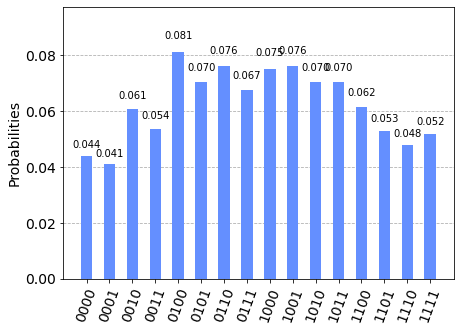

In [20]:
uncertainty_model.measure_all()
job = execute(d_nrml, backend= aer)
plot_histogram(job.result().get_counts(),sort= 'asc')

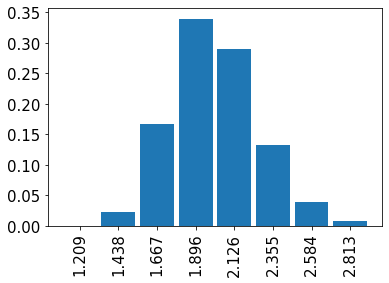

In [21]:
# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()


In [63]:
## amplitue function ~ 
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 2.126

# set the approximation scaling for the payoff function
rescaling_factor = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price]
slopes = [-1, 0]
offsets = [strike_price - low, 0]
f_min = 0
f_max = strike_price - low
european_put_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=rescaling_factor,
)

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
european_put = european_put_objective.compose(uncertainty_model, front=True)

CircuitError: "Trying to compose with another QuantumCircuit which has more 'in' edges."

In [ ]:
european_put_objective.draw()

┌────┐
q1830_0: ┤0   ├
         │    │
q1830_1: ┤1   ├
         │    │
q1830_2: ┤2   ├
         │    │
  q1831: ┤3 F ├
         │    │
   a2_0: ┤4   ├
         │    │
   a2_1: ┤5   ├
         │    │
   a2_2: ┤6   ├
         └────┘

In [23]:
european_put.decompose().draw()

NameError: name 'european_put' is not defined

In [ ]:
european_put.measure_all()
job = execute(d_nrml, backend= aer)
plot_histogram(job.result().get_counts())

VisualizationError: 'Must define target_string when using distance measure.'